In [37]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

'''

    RUMORE bgo + FUNZIONI VARIE
    
'''

rumore = pd.read_csv('fondo.CSV', sep=';')

channel_back = np.array(rumore['Channel']) #taglio i dati per avere lo stesso numero di elementi
counts_back = np.array(rumore['Counts'])
time_back = 9218 #s
frequency_back = counts_back/time_back

allungo_x = np.arange(3990, 100000, 20)
allungo_y = np.zeros(len(allungo_x))
channel_back = np.concatenate((channel_back, allungo_x))
counts_back = np.concatenate((counts_back, allungo_y))
frequency_back = np.concatenate((frequency_back, allungo_y))

def frequency_converter(counts, time_signal=300, frequency_back=frequency_back, time_background=9218, counts_back=counts_back):
    frequency = counts/time_signal
    counts_back = counts_back [:len(frequency)]
    frequency_ = frequency - frequency_back[:len(frequency)]
    for i in range(len(frequency_)):
        if frequency_[i] < 0:
            frequency_[i] = 0
    error = np.sqrt(counts/time_signal**2 + counts_back/time_background**2)
    return frequency_, error

def SNIP_algorithm(spectrum, iterations=40):
    spectrum_log = np.log(np.log(np.sqrt(spectrum + 1) + 1) + 1)
    n_added = iterations
    begin_list = np.ones(n_added) * spectrum_log[0]
    end_list = np.ones(n_added) * spectrum_log[-1]
    spectrum_log = np.concatenate((begin_list, spectrum_log, end_list))
    for k in range(1, iterations+1, 1):
        for i in range(len(spectrum_log[n_added:-n_added])):
            spectrum_log[i] = np.minimum(spectrum_log[i], 0.5 * (spectrum_log[i+k] + spectrum_log[i-k]))
    return (np.exp(np.exp(spectrum_log[n_added:-n_added])-1)-1)**2-1

def multi_SNIP_algorithm(spectrum, channel, iterations=40, delta_n=4):
    spectra = []
    for i in range(iterations-delta_n, iterations+delta_n, 1):
        spectra.append(SNIP_algorithm(spectrum, i))
        if i == iterations-delta_n:
            plt.plot(channel, spectra[0], label='SNIP1', alpha=0.4)
        if i == iterations:
            plt.plot(channel, spectra[delta_n-1], label='SNIP2', alpha=0.4)
        if i == iterations+delta_n-1:
            plt.plot(channel, spectra[2*delta_n-1], label='SNIP3', alpha=0.4)
    
    mean_spectrum = np.mean(spectra, axis=0)
    max_spectrum=spectra[delta_n-2]
    min_spectrum=spectra[delta_n]
    err_spectrum = np.std(spectra, axis=0)/np.sqrt(len(spectra))
    plt.plot(channel, mean_spectrum, label='Mean SNIP')
    plt.errorbar(channel, mean_spectrum, yerr=err_spectrum, fmt='.', alpha=0.01)
    plt.plot(channel, spectrum, label='Spectrum', alpha=0.8)
    plt.legend()
    plt.grid()
    plt.xlabel('Channel')
    plt.ylabel('Frequency')
    plt.show()
    return mean_spectrum, err_spectrum, max_spectrum, min_spectrum

# funzioni per fit
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import norm, chi2

def func(x, A, mu, sigma):
    return A * norm.pdf(x, mu, sigma)

def func2(x, A, mu, sigma, A2, mu2, sigma2):
    return A * norm.pdf(x, mu, sigma) + A2 * norm.pdf(x, mu2, sigma2)

intensità_511KeV = []
err_intensità_511KeV = []
err_sistematico_511KeV = []
intensità_1274_5KeV = []
err_intensità_1274_5KeV = []
err_sistematic0_1274_5KeV = []

Per la rimozione del fondo utilizziamo l'algoritmo di snip iterato prima n-d volte, poi n-(d-1) volte, n-(d-2) ... n ... n+(d-1) e infine n+d volte, cosi da produrre 2d-1 diversi modelli di fondo. Computiamo la media di questi diversi fondi e sarà questa media quella effettiva utilizzata per rimuovere il fondo ed avere la stima dell'area dei picchi del sodio.
Per introdurre un errore sistematico legato alla scelta del numero di iterazioni n per il quale l'algoritmo di snip converge (a occhio), prendiamo il fondo prodotto da n-1 iterazioni e calcoliamo l'area dei picchi del sodio utilizzando questo come fondo da rimuovere. ripetiamo con il fondo prodotto da n+1 iterazioni.
la semidifferenza tra le aree calcolate con questi due fondi sarà il nostro errore sistematico

In [38]:
segnale_0cm = pd.read_csv('0.0cm.CSV', sep=';', engine='python')
channel_0 = np.array(segnale_0cm['Channel'])
counts_0 = np.array(segnale_0cm['Counts'])

'''

    plastica DI SPESSORE 0cm





# calculating frequency and removing background noise
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0, err_background_0 = multi_SNIP_algorithm(frequency_0[0], channel_0, iterations=19, delta_n=10)

frequency_0 = (frequency_0[0] - background_0, np.sqrt(frequency_0[1]**2+err_background_0**2))


# plot
fig = px.line(x=channel_0, y=frequency_0[0], error_y=frequency_0[1], title='Spettro Na con plastica di spessore 0cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()


# fit
ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func)
m = Minuit(ls, A=3.9, mu=1900, sigma=160)
ls.mask = (channel_0 > 1600) & (channel_0 < 3000)
m.migrad()
m.hesse()
display(m)

xaxis = np.linspace(0, 7000, 10000)
yaxis = func(xaxis, *m.values)
plt.errorbar(channel_0, frequency_0[0], frequency_0[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [9400, 13000]
for i in range(len(channel_0)):
    if channel_0[i] > integral_extremes[0] and channel_0[i] < integral_extremes[1]:
        freq_integral.append(frequency_0[0][i])
        channel_integral.append(channel_0[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A"]:.2f} ± {m.errors["A"]:.2f}')

intensità_511KeV.append(m.values['A'])
err_intensità_511KeV.append(m.errors['A'])
'''

'\n\n    plastica DI SPESSORE 0cm\n\n\n\n\n\n# calculating frequency and removing background noise\nfrequency_0 = frequency_converter(counts_0, time_signal=300)\nbackground_0, err_background_0 = multi_SNIP_algorithm(frequency_0[0], channel_0, iterations=19, delta_n=10)\n\nfrequency_0 = (frequency_0[0] - background_0, np.sqrt(frequency_0[1]**2+err_background_0**2))\n\n\n# plot\nfig = px.line(x=channel_0, y=frequency_0[0], error_y=frequency_0[1], title=\'Spettro Na con plastica di spessore 0cm\', labels={\'x\':\'Canale\', \'y\':\'Frequenza [Hz]\'})\nfig.show()\n\n\n# fit\nls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func)\nm = Minuit(ls, A=3.9, mu=1900, sigma=160)\nls.mask = (channel_0 > 1600) & (channel_0 < 3000)\nm.migrad()\nm.hesse()\ndisplay(m)\n\nxaxis = np.linspace(0, 7000, 10000)\nyaxis = func(xaxis, *m.values)\nplt.errorbar(channel_0, frequency_0[0], frequency_0[1], fmt=\'.\', color=\'green\', label=\'Data\', alpha=0.3)\nplt.plot(xaxis, yaxis, color=\'red\', label

In [39]:
'''
# fit
ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func)
m = Minuit(ls, A=50, mu=6000, sigma=200)
ls.mask = (channel_0 > 5200) & (channel_0 < 6500)
m.migrad()
m.hesse()
display(m)

xaxis = np.linspace(5200, 6500, 10000)
yaxis = func(xaxis, *m.values)
plt.errorbar(channel_0, frequency_0[0], frequency_0[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [23000, 26800]
for i in range(len(channel_0)):
    if channel_0[i] > integral_extremes[0] and channel_0[i] < integral_extremes[1]:
        freq_integral.append(frequency_0[0][i])
        channel_integral.append(channel_0[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A"]:.2f} ± {m.errors["A"]:.2f}')

intensità_1274_5KeV.append(m.values['A'])
err_intensità_1274_5KeV.append(m.errors['A'])
'''

'\n# fit\nls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func)\nm = Minuit(ls, A=50, mu=6000, sigma=200)\nls.mask = (channel_0 > 5200) & (channel_0 < 6500)\nm.migrad()\nm.hesse()\ndisplay(m)\n\nxaxis = np.linspace(5200, 6500, 10000)\nyaxis = func(xaxis, *m.values)\nplt.errorbar(channel_0, frequency_0[0], frequency_0[1], fmt=\'.\', color=\'green\', label=\'Data\', alpha=0.3)\nplt.plot(xaxis, yaxis, color=\'red\', label=\'Fit\')\nplt.xlabel(\'Channel\')\nplt.ylabel(\'Frequency\')\nplt.legend()\nplt.title(\'Fit spettro Na\')\nplt.grid()\n\nfreq_integral = []\nchannel_integral = []\nintegral_extremes = [23000, 26800]\nfor i in range(len(channel_0)):\n    if channel_0[i] > integral_extremes[0] and channel_0[i] < integral_extremes[1]:\n        freq_integral.append(frequency_0[0][i])\n        channel_integral.append(channel_0[i])\n\nprint(f\'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}\')\nprint(f\'Area picco con integrale fit: {m.values

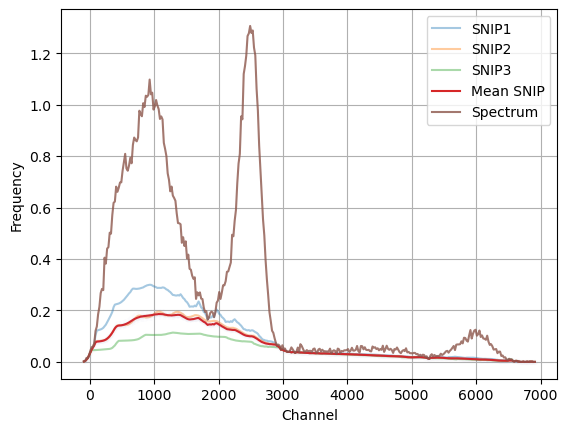

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 49.43 (χ²/ndof = 0.9)      │              Nfcn = 528              │
│ EDM = 0.000102 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    380    │    22     │            │            │         │         │       │
│ 1 │ mu     │  2.506e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma  │   136.8   │    2.3    │            │            │         │         │       │
│ 3 │ A2     │    114    │    22     │            │            │         │         │       │
│ 4 │ mu2    │  2.26e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    196    │    14     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │      477      -66       41   -0.5e3   -0.8e3  -0.23e3 │
│     mu │      -66     13.7       -7       65      101       17 │
│  sigma │       41       -7     5.36      -40      -63      -14 │
│     A2 │   -0.5e3       65      -40      472    0.8e3   0.24e3 │
│    mu2 │   -0.8e3      101      -63    0.8e3 1.32e+03   0.40e3 │
│ sigma2 │  -0.23e3       17      -14   0.24e3   0.40e3      202 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 0.00
Area picco con integrale fit: 494.39 ± 30.81


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 332.4 (χ²/ndof = 6.2)      │              Nfcn = 168              │
│ EDM = 8.43e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │   463.7   │    1.6    │            │            │         │         │       │
│ 1 │ mu     │ 2.4739e3  │ 0.0011e3  │            │            │         │         │       │
│ 2 │ sigma  │   156.9   │    0.9    │            │            │         │         │       │
│ 3 │ A2     │     0     │   0.9e3   │            │            │    0    │  1000   │       │
│ 4 │ mu2    │ 1.3364e3  │ 0.0018e3  │            │            │         │         │       │
│ 5 │ sigma2 │   118.7   │    1.8    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────┐
│        │      A     mu  sigma     A2    mu2 sigma2 │
├────────┼───────────────────────────────────────────┤
│      A │   2.49   -0.1    0.1   -0.0   -0.0   -0.0 │
│     mu │   -0.1   1.15   -0.2    0.0    0.0    0.0 │
│  sigma │    0.1   -0.2  0.869   -0.0   -0.0   -0.0 │
│     A2 │   -0.0    0.0   -0.0    901    0.0    0.0 │
│    mu2 │   -0.0    0.0   -0.0    0.0   3.16    0.0 │
│ sigma2 │   -0.0    0.0   -0.0    0.0    0.0   3.16 │
└────────┴───────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 50.19 (χ²/ndof = 0.9)      │              Nfcn = 586              │
│ EDM = 3.3e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    384    │    22     │            │            │         │         │       │
│ 1 │ mu     │  2.505e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma  │   137.1   │    2.3    │            │            │         │         │       │
│ 3 │ A2     │    114    │    21     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │  2.26e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    197    │    15     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │      467      -66       40   -0.5e3   -0.8e3  -0.24e3 │
│     mu │      -66     13.6       -7       65      104       21 │
│  sigma │       40       -7     5.23      -39      -63      -15 │
│     A2 │   -0.5e3       65      -39      462    0.8e3   0.25e3 │
│    mu2 │   -0.8e3      104      -63    0.8e3 1.35e+03   0.43e3 │
│ sigma2 │  -0.24e3       21      -15   0.25e3   0.43e3      212 │
└────────┴───────────────────────────────────────────────────────┘

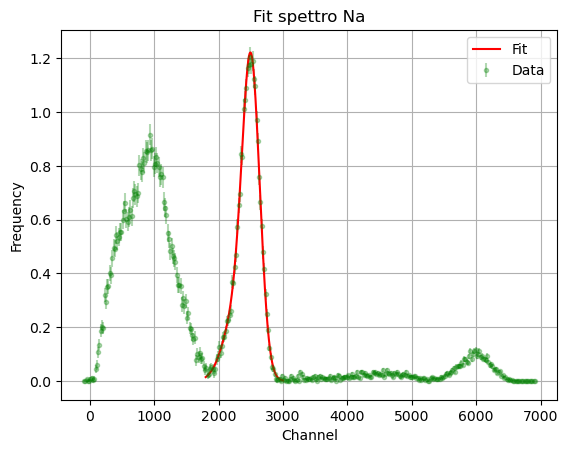

In [40]:
'''

    plastica DI SPESSORE 0.4cm

'''

segnale_04cm = pd.read_csv('0.4cm.csv', sep=';', engine='python')
channel_04 = np.array(segnale_0cm['Channel'])
counts_04 = np.array(segnale_04cm['Counts'])
# crea un array

# calculating frequency and removing background noise
frequency_04_raw= frequency_converter(counts_04, time_signal=1000)
background_04, err_background_04, max_back, min_back= multi_SNIP_algorithm(frequency_04_raw[0], channel_04, iterations=18, delta_n=4)

frequency_04 = (frequency_04_raw[0] - background_04, np.sqrt(frequency_04_raw[1]**2+err_background_04**2))
freq_max = (frequency_04_raw[0] - max_back, np.sqrt(frequency_04_raw[1]**2+err_background_04**2))
freq_min = (frequency_04_raw[0] - min_back, np.sqrt(frequency_04_raw[1]**2+err_background_04**2))

# plot
fig = px.line(x=channel_04, y=frequency_04_raw[0], error_y=frequency_04[1], title='Spettro Na con plastica di spessore 0.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()

# fit
ls = LeastSquares(channel_04, frequency_04[0], frequency_04[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=10, mu2=2000, sigma2=200)
ls.mask = (channel_04 > 1800) & (channel_04 < 3000)
m.migrad()
m.hesse()
display(m)

xaxis = np.linspace(1800, 3000, 3000)
yaxis = func2(xaxis, *m.values)
plt.errorbar(channel_04, frequency_04[0], frequency_04[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [12000, 15600]
for i in range(len(channel_04)):
    if channel_04[i] > integral_extremes[0] and channel_04[i] < integral_extremes[1]:
        freq_integral.append(frequency_04[0][i])
        channel_integral.append(channel_04[i])
        
Area=m.values['A']+m.values['A2']
err_Area=np.sqrt(m.errors['A']**2+m.errors['A2']**2)
print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {Area:.2f} ± {err_Area:.2f}')

intensità_511KeV.append(m.values['A']+m.values['A2'])
err_intensità_511KeV.append(np.sqrt(m.errors['A']**2+m.errors['A2']**2))

#sistematici
ls = LeastSquares(channel_04, freq_max[0], freq_max[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=10, mu2=2000, sigma2=200)
ls.mask = (channel_04 > 1800) & (channel_04 < 3000)
m.limits['A2']= (0, 1000)
m.migrad()
m.hesse()
display(m)
sist1 = m.values['A']+m.values['A2']

ls = LeastSquares(channel_04, freq_min[0], freq_min[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=10, mu2=2100, sigma2=200)
ls.mask = (channel_04 > 1800) & (channel_04 < 3000)
m.limits['A2']= (0, 1000)
m.migrad()
m.hesse()
display(m)
sist2 = m.values['A']+m.values['A2']

err_sist = np.abs(sist1 - sist2)/2

err_sistematico_511KeV.append(err_sist)



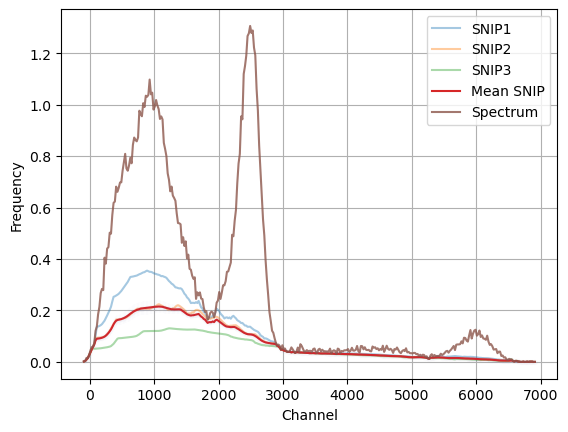

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 79.32 (χ²/ndof = 1.1)      │             Nfcn = 1428              │
│ EDM = 3.08e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │   57.3    │    1.2    │            │            │         │         │       │
│ 1 │ mu    │  5.974e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma │    232    │     4     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     A    mu sigma │
├───────┼───────────────────┤
│     A │  1.46  -0.8   1.0 │
│    mu │  -0.8  32.7    -9 │
│ sigma │   1.0    -9  19.9 │
└───────┴───────────────────┘

Area picco con integrale trapezoidale: 0.00
Area picco con integrale fit: 57.29 ± 1.21


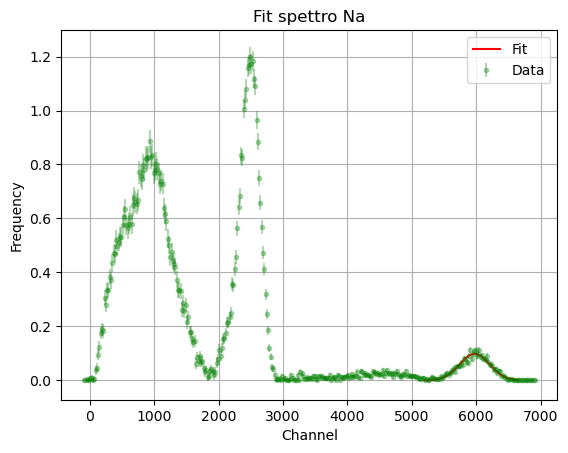

In [41]:
background_04, err_background_04, max_back, min_back= multi_SNIP_algorithm(frequency_04_raw[0], channel_04, iterations=17, delta_n=4)

frequency_04 = (frequency_04_raw[0] - background_04, np.sqrt(frequency_04_raw[1]**2+err_background_04**2))
freq_max = (frequency_04_raw[0] - max_back, np.sqrt(frequency_04_raw[1]**2+err_background_04**2))
freq_min = (frequency_04_raw[0] - min_back, np.sqrt(frequency_04_raw[1]**2+err_background_04**2))

# fit
ls = LeastSquares(channel_04, frequency_04[0], frequency_04[1], func)
m = Minuit(ls, A=0.25, mu=6000, sigma=300)
ls.mask = (channel_04 > 5200) & (channel_04 < 6650)
m.migrad()
m.hesse()
display(m)


xaxis = np.linspace(5200, 6650, 1000)
yaxis = func(xaxis, *m.values)
plt.errorbar(channel_04, frequency_04[0], frequency_04[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [27600, 31200]

for i in range(len(channel_04)):
    if channel_04[i] > integral_extremes[0] and channel_04[i] < integral_extremes[1]:
        freq_integral.append(frequency_04[0][i])
        channel_integral.append(channel_04[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A"]:.2f} ± {m.errors["A"]:.2f}')

intensità_1274_5KeV.append(m.values['A'])
err_intensità_1274_5KeV.append(m.errors['A'])

#sistematici
ls = LeastSquares(channel_04, freq_max[0], freq_max[1], func)
m = Minuit(ls, A=0.25, mu=6000, sigma=300)
ls.mask = (channel_04 > 5200) & (channel_04 < 6650)
m.migrad()
m.hesse()
sist1 = m.values['A']

ls = LeastSquares(channel_04, freq_min[0], freq_min[1], func)
m = Minuit(ls, A=0.25, mu=6000, sigma=300)
ls.mask = (channel_04 > 5200) & (channel_04 < 6650)
m.migrad()
m.hesse()
sist2 = m.values['A']

err_sist = np.abs(sist1 - sist2)/2

err_sistematic0_1274_5KeV.append(err_sist)


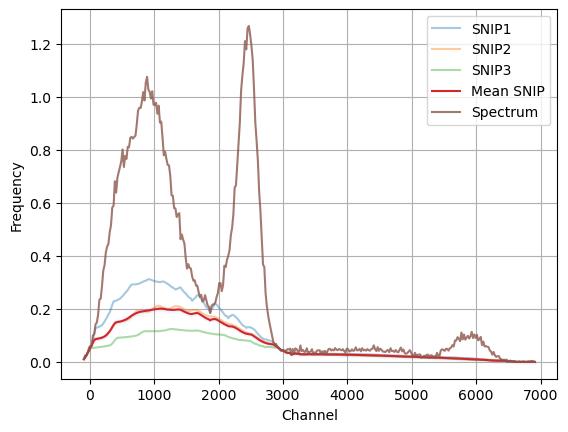

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 47.05 (χ²/ndof = 0.9)      │              Nfcn = 427              │
│ EDM = 0.000172 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    358    │    23     │            │            │         │         │       │
│ 1 │ mu     │  2.472e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma  │   137.0   │    2.4    │            │            │         │         │       │
│ 3 │ A2     │    106    │    23     │            │            │         │         │       │
│ 4 │ mu2    │  2.23e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    199    │    18     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │      529      -68       47   -0.5e3   -1.0e3  -0.33e3 │
│     mu │      -68     13.4       -8       67      119       25 │
│  sigma │       47       -8     5.94      -46      -82      -22 │
│     A2 │   -0.5e3       67      -46      532    1.0e3   0.34e3 │
│    mu2 │   -1.0e3      119      -82    1.0e3 1.83e+03   0.64e3 │
│ sigma2 │  -0.33e3       25      -22   0.34e3   0.64e3      324 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 0.00
Area picco con integrale fit: 464.07 ± 32.56


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 47.05 (χ²/ndof = 0.9)      │              Nfcn = 645              │
│ EDM = 1.05e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    381    │    25     │            │            │         │         │       │
│ 1 │ mu     │  2.468e3  │  0.008e3  │            │            │         │         │       │
│ 2 │ sigma  │   137.1   │    3.4    │            │            │         │         │       │
│ 3 │ A2     │    65     │    26     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │  2.18e3   │  0.06e3   │            │            │         │         │       │
│ 5 │ sigma2 │    146    │    29     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │      645     -210       80   -0.7e3   -1.4e3   -0.7e3 │
│     mu │     -210     70.6      -27      210      470      220 │
│  sigma │       80      -27     11.6      -81     -177      -81 │
│     A2 │   -0.7e3      210      -81      669    1.5e3    0.7e3 │
│    mu2 │   -1.4e3      470     -177    1.5e3 3.25e+03    1.6e3 │
│ sigma2 │   -0.7e3      220      -81    0.7e3    1.6e3      833 │
└────────┴───────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 48.18 (χ²/ndof = 0.9)      │              Nfcn = 335              │
│ EDM = 1.99e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    362    │    21     │            │            │         │         │       │
│ 1 │ mu     │ 2.4713e3  │ 0.0035e3  │            │            │         │         │       │
│ 2 │ sigma  │   137.5   │    2.3    │            │            │         │         │       │
│ 3 │ A2     │    106    │    21     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │  2.22e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    201    │    18     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │      454      -60       41   -0.4e3   -0.8e3  -0.30e3 │
│     mu │      -60     12.3       -7       59      109       24 │
│  sigma │       41       -7     5.48      -41      -74      -21 │
│     A2 │   -0.4e3       59      -41      456    0.8e3   0.31e3 │
│    mu2 │   -0.8e3      109      -74    0.8e3 1.65e+03   0.59e3 │
│ sigma2 │  -0.30e3       24      -21   0.31e3   0.59e3      310 │
└────────┴───────────────────────────────────────────────────────┘

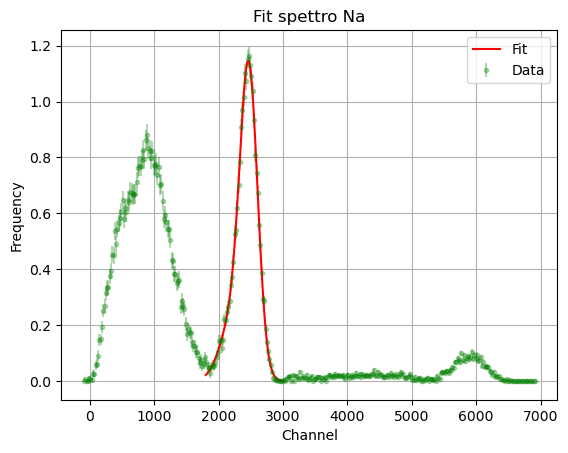

In [42]:
'''

    plastica DI SPESSORE 1cm

'''

segnale_1cm = pd.read_csv('1.0cm.csv', sep=';', engine='python')
channel_1 = np.array(segnale_0cm['Channel'])
counts_1 = np.array(segnale_1cm['Counts'])

# calculating frequency and removing background noise
frequency_1_raw = frequency_converter(counts_1, time_signal=1200)
background_1, err_background_1, max_back, min_back= multi_SNIP_algorithm(frequency_1_raw[0], channel_1, iterations=18, delta_n=4)

frequency_1 = (frequency_1_raw[0] - background_1, np.sqrt(frequency_1_raw[1]**2+err_background_1**2))
freq_max = (frequency_1_raw[0] - max_back, np.sqrt(frequency_1_raw[1]**2+err_background_1**2))
freq_min = (frequency_1_raw[0] - min_back, np.sqrt(frequency_1_raw[1]**2+err_background_1**2))

# plot
fig = px.line(x=channel_1, y=frequency_1_raw[0], error_y=frequency_1[1], title='Spettro Na con plastica di spessore 0.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()

# fit
ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=10, mu2=2000, sigma2=200)
ls.mask = (channel_1 > 1800) & (channel_1 < 3000)
m.migrad()
m.hesse()
display(m)

xaxis = np.linspace(1800, 3000, 3000)
yaxis = func2(xaxis, *m.values)
plt.errorbar(channel_1, frequency_1[0], frequency_1[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [12000, 15600]
for i in range(len(channel_1)):
    if channel_1[i] > integral_extremes[0] and channel_1[i] < integral_extremes[1]:
        freq_integral.append(frequency_1[0][i])
        channel_integral.append(channel_1[i])
        
Area=m.values['A']+m.values['A2']
err_Area=np.sqrt(m.errors['A']**2+m.errors['A2']**2)
print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {Area:.2f} ± {err_Area:.2f}')

intensità_511KeV.append(m.values['A']+m.values['A2'])
err_intensità_511KeV.append(np.sqrt(m.errors['A']**2+m.errors['A2']**2))

#sistematici
ls = LeastSquares(channel_1, freq_max[0], freq_max[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=10, mu2=2000, sigma2=200)
ls.mask = (channel_1 > 1800) & (channel_1 < 3000)
m.limits['A2']= (0, 1000)
m.migrad()
m.hesse()
display(m)
sist1 = m.values['A']+m.values['A2']

ls = LeastSquares(channel_1, freq_min[0], freq_min[1], func2)
m = Minuit(ls, A=450, mu=2500, sigma=160, A2=10, mu2=2100, sigma2=200)
ls.mask = (channel_1 > 1800) & (channel_1 < 3000)
m.limits['A2']= (0, 1000)
m.migrad()
m.hesse()
display(m)
sist2 = m.values['A']+m.values['A2']

err_sist = np.abs(sist1 - sist2)/2

err_sistematico_511KeV.append(err_sist)

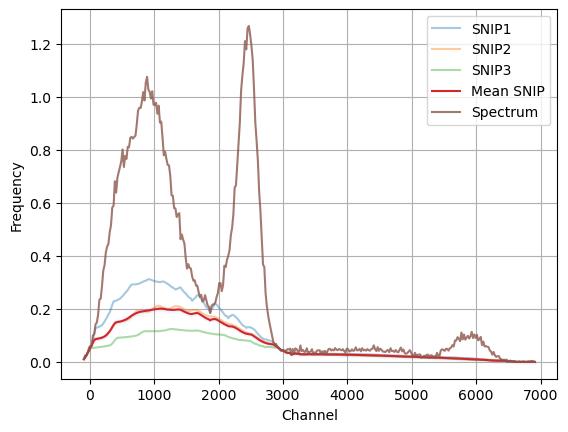

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 77.01 (χ²/ndof = 1.4)      │             Nfcn = 1437              │
│ EDM = 5.5e-08 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │   53.9    │    1.1    │            │            │         │         │       │
│ 1 │ mu    │  5.890e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma │    237    │     5     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     A    mu sigma │
├───────┼───────────────────┤
│     A │  1.17  -0.4   1.2 │
│    mu │  -0.4  28.5    -3 │
│ sigma │   1.2    -3  22.2 │
└───────┴───────────────────┘

Area picco con integrale trapezoidale: 0.00
Area picco con integrale fit: 53.85 ± 1.08


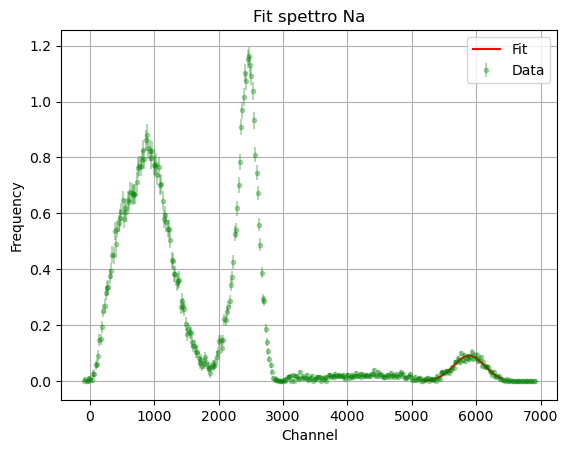

In [43]:

background_1, err_background_1, max_back, min_back= multi_SNIP_algorithm(frequency_1_raw[0], channel_1, iterations=18, delta_n=4)

frequency_1 = (frequency_1_raw[0] - background_1, np.sqrt(frequency_1_raw[1]**2+err_background_1**2))
freq_max = (frequency_1_raw[0] - max_back, np.sqrt(frequency_1_raw[1]**2+err_background_1**2))
freq_min = (frequency_1_raw[0] - min_back, np.sqrt(frequency_1_raw[1]**2+err_background_1**2))



# fit
ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func)
m = Minuit(ls, A=0.25, mu=6000, sigma=400)
ls.mask = (channel_1 > 5200) & (channel_1 < 6400)
m.migrad()
m.hesse()
display(m)


xaxis = np.linspace(5200, 6400, 10000)
yaxis = func(xaxis, *m.values)
plt.errorbar(channel_1, frequency_1[0], frequency_1[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [27500, 32000]
for i in range(len(channel_1)):
    if channel_1[i] > integral_extremes[0] and channel_1[i] < integral_extremes[1]:
        freq_integral.append(frequency_1[0][i])
        channel_integral.append(channel_1[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A"]:.2f} ± {m.errors["A"]:.2f}')

intensità_1274_5KeV.append(m.values['A'])
err_intensità_1274_5KeV.append(m.errors['A'])

#sistematici
ls = LeastSquares(channel_04, freq_max[0], freq_max[1], func)
m = Minuit(ls, A=0.25, mu=6000, sigma=400)
ls.mask = (channel_1 > 5200) & (channel_1 < 6400)
m.migrad()
m.hesse()
sist1 = m.values['A']

ls = LeastSquares(channel_04, freq_min[0], freq_min[1], func)
m = Minuit(ls, A=0.25, mu=6000, sigma=400)
ls.mask = (channel_1 > 5200) & (channel_1 < 6400)
m.migrad()
m.hesse()
sist2 = m.values['A']

err_sist = np.abs(sist1 - sist2)/2

err_sistematic0_1274_5KeV.append(err_sist)



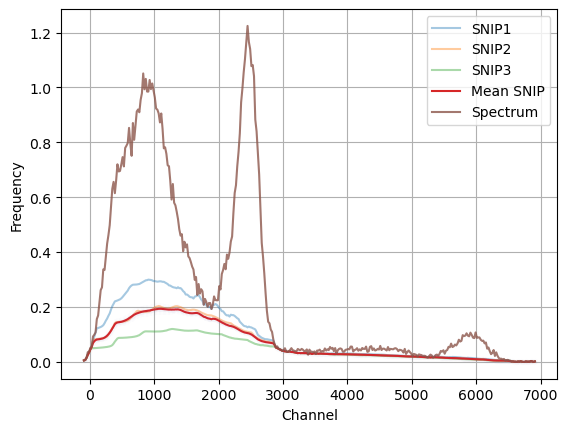

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 61.46 (χ²/ndof = 1.1)      │              Nfcn = 413              │
│ EDM = 2.26e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    326    │    19     │            │            │         │         │       │
│ 1 │ mu     │  2.480e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma  │   133.1   │    2.3    │            │            │         │         │       │
│ 3 │ A2     │    115    │    19     │            │            │         │         │       │
│ 4 │ mu2    │  2.237e3  │  0.032e3  │            │            │         │         │       │
│ 5 │ sigma2 │    195    │    13     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │      354      -54       36  -0.35e3  -0.58e3  -0.18e3 │
│     mu │      -54     12.9       -7       53       85       14 │
│  sigma │       36       -7     5.39      -35      -56      -13 │
│     A2 │  -0.35e3       53      -35      353   0.58e3   0.19e3 │
│    mu2 │  -0.58e3       85      -56   0.58e3 1.01e+03   0.32e3 │
│ sigma2 │  -0.18e3       14      -13   0.19e3   0.32e3      179 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 0.00
Area picco con integrale fit: 441.19 ± 26.59


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 60.53 (χ²/ndof = 1.1)      │              Nfcn = 504              │
│ EDM = 1.6e-08 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    322    │    31     │            │            │         │         │       │
│ 1 │ mu     │  2.483e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma  │   131.2   │    2.8    │            │            │         │         │       │
│ 3 │ A2     │    103    │    31     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │  2.25e3   │  0.05e3   │            │            │         │         │       │
│ 5 │ sigma2 │    172    │    21     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │      976     -190       76     -1e3   -1.6e3   -0.6e3 │
│     mu │     -190     39.5      -16      190      300      100 │
│  sigma │       76      -16     7.98      -75     -120      -38 │
│     A2 │     -1e3      190      -75      985    1.6e3    0.6e3 │
│    mu2 │   -1.6e3      300     -120    1.6e3 2.66e+03    1.0e3 │
│ sigma2 │   -0.6e3      100      -38    0.6e3    1.0e3      423 │
└────────┴───────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 62.2 (χ²/ndof = 1.2)       │              Nfcn = 555              │
│ EDM = 5.39e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    329    │    17     │            │            │         │         │       │
│ 1 │ mu     │ 2.4792e3  │ 0.0034e3  │            │            │         │         │       │
│ 2 │ sigma  │   133.7   │    2.3    │            │            │         │         │       │
│ 3 │ A2     │    117    │    17     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │  2.229e3  │  0.030e3  │            │            │         │         │       │
│ 5 │ sigma2 │    199    │    13     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │       A      mu   sigma      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│      A │     301     -46      32 -0.29e3  -0.5e3 -0.16e3 │
│     mu │     -46    11.5      -6      45      75      11 │
│  sigma │      32      -6    5.06     -31     -51     -11 │
│     A2 │ -0.29e3      45     -31     299   0.5e3  0.17e3 │
│    mu2 │  -0.5e3      75     -51   0.5e3     896  0.28e3 │
│ sigma2 │ -0.16e3      11     -11  0.17e3  0.28e3     165 │
└────────┴─────────────────────────────────────────────────┘

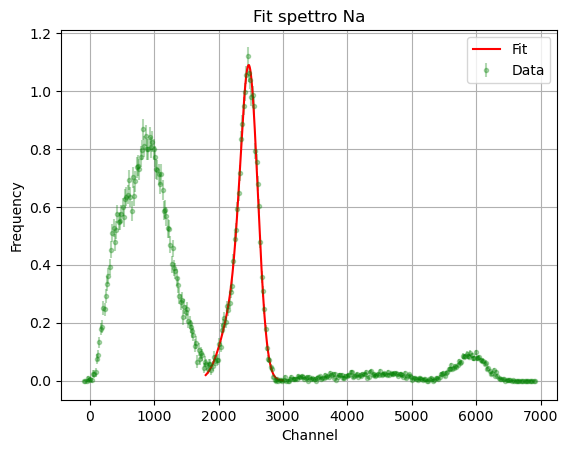

In [44]:
'''

    plastica DI SPESSORE 1.4cm

'''

segnale_14cm = pd.read_csv('1.4cm.csv', sep=';', engine='python')
channel_14 = np.array(segnale_0cm['Channel'])
counts_14 = np.array(segnale_14cm['Counts'])

# calculating frequency and removing background noise
frequency_14_raw = frequency_converter(counts_14, time_signal=1200)
background_14, err_background_14, max_back, min_back= multi_SNIP_algorithm(frequency_14_raw[0], channel_14, iterations=18, delta_n=4)

frequency_14 = (frequency_14_raw[0] - background_14, np.sqrt(frequency_14_raw[1]**2+err_background_14**2))
freq_max = (frequency_14_raw[0] - max_back, np.sqrt(frequency_14_raw[1]**2+err_background_14**2))
freq_min = (frequency_14_raw[0] - min_back, np.sqrt(frequency_14_raw[1]**2+err_background_14**2))

# plot
fig = px.line(x=channel_14, y=frequency_14[0], error_y=frequency_14[1], title='Spettro Na con plastica di spessore 0.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()

# fit
ls = LeastSquares(channel_14, frequency_14[0], frequency_14[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=10, mu2=2000, sigma2=200)
ls.mask = (channel_14 > 1800) & (channel_14 < 3000)
m.migrad()
m.hesse()
display(m)

xaxis = np.linspace(1800, 3000, 3000)
yaxis = func2(xaxis, *m.values)
plt.errorbar(channel_14, frequency_14[0], frequency_14[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [12000, 15600]
for i in range(len(channel_14)):
    if channel_14[i] > integral_extremes[0] and channel_14[i] < integral_extremes[1]:
        freq_integral.append(frequency_14[0][i])
        channel_integral.append(channel_14[i])
        
Area=m.values['A']+m.values['A2']
err_Area=np.sqrt(m.errors['A']**2+m.errors['A2']**2)
print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {Area:.2f} ± {err_Area:.2f}')

intensità_511KeV.append(m.values['A']+m.values['A2'])
err_intensità_511KeV.append(np.sqrt(m.errors['A']**2+m.errors['A2']**2))

#sistematici
ls = LeastSquares(channel_14, freq_max[0], freq_max[1], func2)
m = Minuit(ls, A=470, mu=2500, sigma=200, A2=10, mu2=2100, sigma2=200)
ls.mask = (channel_14 > 1800) & (channel_14 < 3000)
m.limits['A2']= (0, 1000)
m.migrad()
m.hesse()
display(m)
sist1 = m.values['A']+m.values['A2']

ls = LeastSquares(channel_14, freq_min[0], freq_min[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=2, mu2=2100, sigma2=300)
ls.mask = (channel_14 > 1800) & (channel_14 < 3000)
m.limits['A2']= (0, 1000)
m.migrad()
m.hesse()
display(m)
sist2 = m.values['A']+m.values['A2']

err_sist = np.abs(sist1 - sist2)/2

err_sistematico_511KeV.append(err_sist)

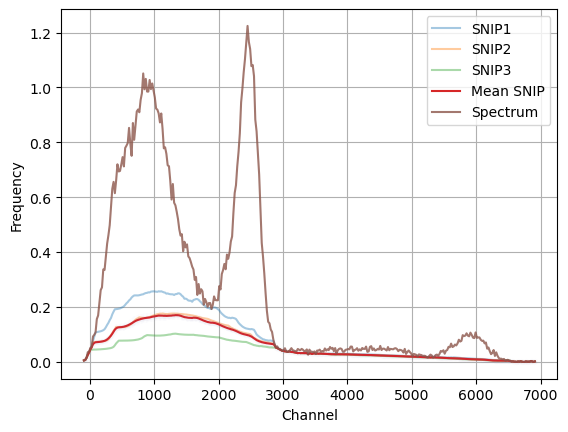

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 73.78 (χ²/ndof = 1.2)      │             Nfcn = 2067              │
│ EDM = 6.87e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │   51.7    │    1.1    │            │            │         │         │       │
│ 1 │ mu    │  5.901e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma │    234    │     5     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     A    mu sigma │
├───────┼───────────────────┤
│     A │  1.13  -0.4   1.3 │
│    mu │  -0.4  29.1    -5 │
│ sigma │   1.3    -5  24.3 │
└───────┴───────────────────┘

Area picco con integrale trapezoidale: 0.00
Area picco con integrale fit: 51.74 ± 1.06


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 70.62 (χ²/ndof = 1.1)      │             Nfcn = 2058              │
│ EDM = 2.8e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │   51.3    │    1.1    │            │            │         │         │       │
│ 1 │ mu    │  5.903e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma │    232    │     5     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     A    mu sigma │
├───────┼───────────────────┤
│     A │  1.12  -0.5   1.3 │
│    mu │  -0.5    29    -4 │
│ sigma │   1.3    -4  23.9 │
└───────┴───────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 73.15 (χ²/ndof = 1.2)      │              Nfcn = 104              │
│ EDM = 1.47e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │   52.2    │    1.1    │            │            │         │         │       │
│ 1 │ mu    │  5.901e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma │    235    │     5     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     A    mu sigma │
├───────┼───────────────────┤
│     A │  1.13  -0.4   1.3 │
│    mu │  -0.4  28.8    -4 │
│ sigma │   1.3    -4  24.2 │
└───────┴───────────────────┘

0.44472271022364396


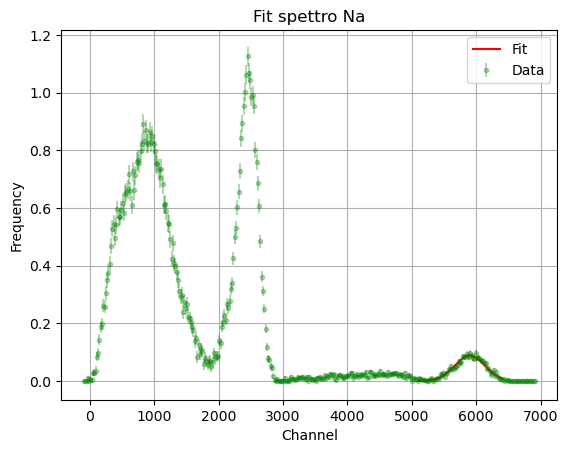

In [45]:
background_14, err_background_14, max_back, min_back= multi_SNIP_algorithm(frequency_14_raw[0], channel_14, iterations=19, delta_n=4)

frequency_14 = (frequency_14_raw[0] - background_14, np.sqrt(frequency_14_raw[1]**2+err_background_14**2))
freq_max = (frequency_14_raw[0] - max_back, np.sqrt(frequency_14_raw[1]**2+err_background_14**2))
freq_min = (frequency_14_raw[0] - min_back, np.sqrt(frequency_14_raw[1]**2+err_background_14**2))

# fit
ls = LeastSquares(channel_14, frequency_14[0], frequency_14[1], func)
m = Minuit(ls, A=0.25, mu=6000, sigma=400)
ls.mask = (channel_14 > 5100) & (channel_14 < 6400)
m.migrad()
m.hesse()
display(m)


xaxis = np.linspace(5100, 6400, 10000)
yaxis = func(xaxis, *m.values)
plt.errorbar(channel_14, frequency_14[0], frequency_14[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [28000, 32000]
for i in range(len(channel_14)):
    if channel_14[i] > integral_extremes[0] and channel_14[i] < integral_extremes[1]:
        freq_integral.append(frequency_14[0][i])
        channel_integral.append(channel_14[i])
        
print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A"]:.2f} ± {m.errors["A"]:.2f}')

intensità_1274_5KeV.append(m.values['A'])
err_intensità_1274_5KeV.append(m.errors['A'])

#sistematici
ls = LeastSquares(channel_04, freq_max[0], freq_max[1], func)
m = Minuit(ls, A=0.25, mu=6000, sigma=400)
ls.mask = (channel_14 > 5100) & (channel_14 < 6400)
m.migrad()
m.hesse()
display(m)
sist1 = m.values['A']

ls = LeastSquares(channel_04, freq_min[0], freq_min[1], func)
m = Minuit(ls, A=100, mu=5900, sigma=400)
ls.mask = (channel_14 > 5100) & (channel_14 < 6400)
m.migrad()
m.hesse()
display(m)
sist2 = m.values['A']

err_sist = np.abs(sist1 - sist2)/2
print(err_sist)


err_sistematic0_1274_5KeV.append(err_sist)

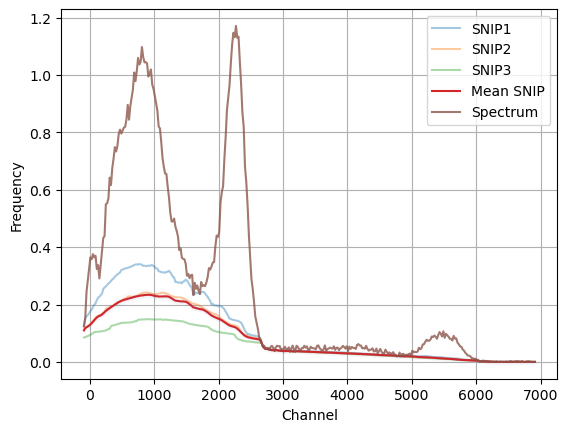

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 28.45 (χ²/ndof = 0.7)      │              Nfcn = 697              │
│ EDM = 4.77e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    324    │    24     │            │            │         │         │       │
│ 1 │ mu     │  2.275e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma  │   135.2   │    2.7    │            │            │         │         │       │
│ 3 │ A2     │    98     │    25     │            │            │         │         │       │
│ 4 │ mu2    │  2.02e3   │  0.05e3   │            │            │         │         │       │
│ 5 │ sigma2 │    200    │    24     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │      598      -77       58   -0.6e3   -1.2e3   -0.5e3 │
│     mu │      -77     15.1       -9       76      156       37 │
│  sigma │       58       -9     7.53      -57     -115      -35 │
│     A2 │   -0.6e3       76      -57      616    1.2e3    0.5e3 │
│    mu2 │   -1.2e3      156     -115    1.2e3 2.61e+03    1.0e3 │
│ sigma2 │   -0.5e3       37      -35    0.5e3    1.0e3      567 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 0.00
Area picco con integrale fit: 421.69 ± 34.83


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 29.26 (χ²/ndof = 0.8)      │              Nfcn = 769              │
│ EDM = 8.44e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    85     │    34     │            │            │         │         │       │
│ 1 │ mu     │  2.04e3   │  0.07e3   │            │            │         │         │       │
│ 2 │ sigma  │    182    │    30     │            │            │         │         │       │
│ 3 │ A2     │    320    │    33     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │  2.276e3  │  0.006e3  │            │            │         │         │       │
│ 5 │ sigma2 │   134.1   │    3.0    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │ 1.13e+03    2.3e3    0.9e3   -1.1e3      177      -88 │
│     mu │    2.3e3 4.95e+03    1.9e3   -2.3e3      366     -179 │
│  sigma │    0.9e3    1.9e3      886   -0.9e3      119      -58 │
│     A2 │   -1.1e3   -2.3e3   -0.9e3 1.11e+03     -177       88 │
│    mu2 │      177      366      119     -177     33.4      -16 │
│ sigma2 │      -88     -179      -58       88      -16     9.32 │
└────────┴───────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 29.73 (χ²/ndof = 0.8)      │             Nfcn = 1291              │
│ EDM = 8.16e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    327    │    21     │            │            │         │         │       │
│ 1 │ mu     │ 2.2733e3  │ 0.0035e3  │            │            │         │         │       │
│ 2 │ sigma  │   135.8   │    2.6    │            │            │         │         │       │
│ 3 │ A2     │    101    │    21     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │  2.01e3   │  0.05e3   │            │            │         │         │       │
│ 5 │ sigma2 │    208    │    22     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │      440      -57       47   -0.4e3   -0.9e3   -0.3e3 │
│     mu │      -57     12.3       -8       54      119       19 │
│  sigma │       47       -8     6.79      -46      -96      -26 │
│     A2 │   -0.4e3       54      -46      451    0.9e3    0.4e3 │
│    mu2 │   -0.9e3      119      -96    0.9e3 2.03e+03    0.7e3 │
│ sigma2 │   -0.3e3       19      -26    0.4e3    0.7e3      466 │
└────────┴───────────────────────────────────────────────────────┘

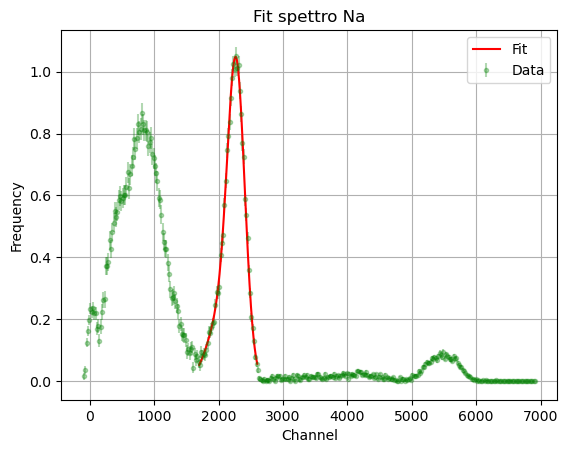

In [46]:
'''

    plastica DI SPESSORE 2cm

'''

segnale_20 = pd.read_csv('2.0cm.csv', sep=';', engine='python')
channel_20 = np.array(segnale_0cm['Channel'])
counts_20 = np.array(segnale_20['Counts'])

# calculating frequency and removing background noise
frequency_20_raw = frequency_converter(counts_20, time_signal=1500)
background_20, err_background_20, max_back, min_back= multi_SNIP_algorithm(frequency_20_raw[0], channel_20, iterations=18, delta_n=4)

frequency_20 = (frequency_20_raw[0] - background_20, np.sqrt(frequency_20_raw[1]**2+err_background_20**2))
freq_max = (frequency_20_raw[0] - max_back, np.sqrt(frequency_20_raw[1]**2+err_background_20**2))
freq_min = (frequency_20_raw[0] - min_back, np.sqrt(frequency_20_raw[1]**2+err_background_20**2))

# plot
fig = px.line(x=channel_20, y=frequency_20_raw[0], error_y=frequency_20[1], title='Spettro Na con plastica di spessore 0.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()

# fit
ls = LeastSquares(channel_20, frequency_20[0], frequency_20[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=10, mu2=2000, sigma2=200)
ls.mask = (channel_20 > 1700) & (channel_20 < 2600)
m.migrad()
m.hesse()
display(m)

xaxis = np.linspace(1700, 2600, 3000)
yaxis = func2(xaxis, *m.values)
plt.errorbar(channel_20, frequency_20[0], frequency_20[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [12000, 15600]
for i in range(len(channel_20)):
    if channel_20[i] > integral_extremes[0] and channel_20[i] < integral_extremes[1]:
        freq_integral.append(frequency_20[0][i])
        channel_integral.append(channel_20[i])
        
Area=m.values['A']+m.values['A2']
err_Area=np.sqrt(m.errors['A']**2+m.errors['A2']**2)
print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {Area:.2f} ± {err_Area:.2f}')

intensità_511KeV.append(m.values['A']+m.values['A2'])
err_intensità_511KeV.append(np.sqrt(m.errors['A']**2+m.errors['A2']**2))

#sistematici
ls = LeastSquares(channel_20, freq_max[0], freq_max[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=10, mu2=2000, sigma2=200)
ls.mask = (channel_20 > 1700) & (channel_20 < 2600)
m.limits['A2']= (0, 1000)
m.migrad()
m.hesse()
display(m)
sist1 = m.values['A']+m.values['A2']

ls = LeastSquares(channel_20, freq_min[0], freq_min[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=10, mu2=2100, sigma2=200)
ls.mask = (channel_20 > 1700) & (channel_20 < 2600)
m.limits['A2']= (0, 1000)
m.migrad()
m.hesse()
display(m)
sist2 = m.values['A']+m.values['A2']

err_sist = np.abs(sist1 - sist2)/2

err_sistematico_511KeV.append(err_sist)

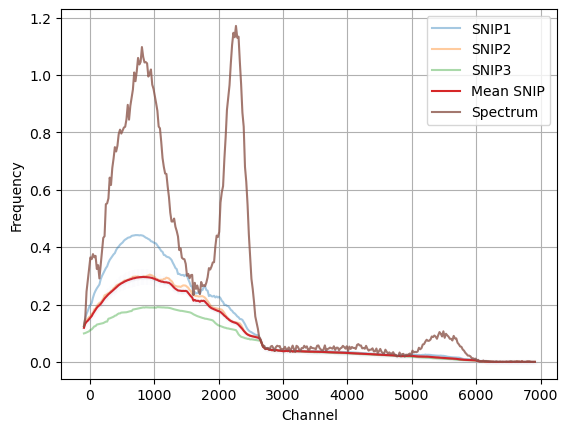

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 46.04 (χ²/ndof = 1.0)      │             Nfcn = 1479              │
│ EDM = 4.53e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │   49.2    │    1.0    │            │            │         │         │       │
│ 1 │ mu    │  5.472e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma │    230    │     5     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     A    mu sigma │
├───────┼───────────────────┤
│     A │ 0.953  -0.8   1.3 │
│    mu │  -0.8  28.1    -6 │
│ sigma │   1.3    -6  20.6 │
└───────┴───────────────────┘

Area picco con integrale trapezoidale: 0.00
Area picco con integrale fit: 49.18 ± 0.98


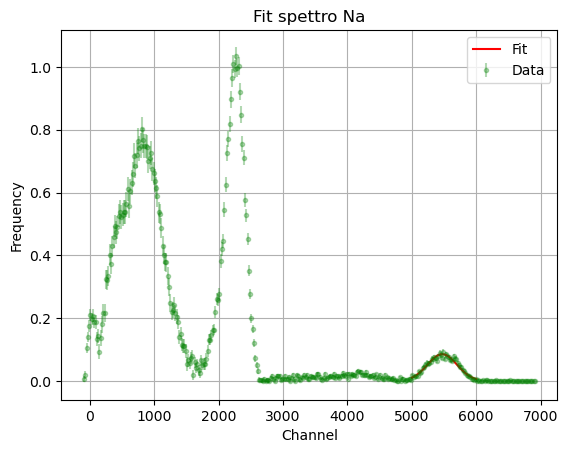

In [47]:
background_20, err_background_20, max_back, min_back= multi_SNIP_algorithm(frequency_20_raw[0], channel_20, iterations=16, delta_n=4)

frequency_20 = (frequency_20_raw[0] - background_20, np.sqrt(frequency_20_raw[1]**2+err_background_20**2))
freq_max = (frequency_20_raw[0] - max_back, np.sqrt(frequency_20_raw[1]**2+err_background_20**2))
freq_min = (frequency_20_raw[0] - min_back, np.sqrt(frequency_20_raw[1]**2+err_background_20**2))



# fit
ls = LeastSquares(channel_20, frequency_20[0], frequency_20[1], func)
m = Minuit(ls, A=0.25, mu=5500, sigma=400)
ls.mask = (channel_20 > 5000) & (channel_20 < 6000)
m.migrad()
m.hesse()
display(m)


xaxis = np.linspace(5000, 6000, 10000)
yaxis = func(xaxis, *m.values)
plt.errorbar(channel_20, frequency_20[0], frequency_20[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [25900, 29800]
for i in range(len(channel_20)):
    if channel_20[i] > integral_extremes[0] and channel_20[i] < integral_extremes[1]:
        freq_integral.append(frequency_20[0][i])
        channel_integral.append(channel_20[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A"]:.2f} ± {m.errors["A"]:.2f}')

intensità_1274_5KeV.append(m.values['A'])
err_intensità_1274_5KeV.append(m.errors['A'])

#sistematici

ls = LeastSquares(channel_04, freq_max[0], freq_max[1], func)
m = Minuit(ls, A=0.25, mu=5500, sigma=400)
ls.mask = (channel_20 > 5000) & (channel_20 < 6000)
m.migrad()
m.hesse()
sist1 = m.values['A']

ls = LeastSquares(channel_04, freq_min[0], freq_min[1], func)
m = Minuit(ls, A=0.25, mu=5500, sigma=400)
ls.mask = (channel_20 > 5000) & (channel_20 < 6000)
m.migrad()
m.hesse()
sist2 = m.values['A']

err_sist = np.abs(sist1 - sist2)/2

err_sistematic0_1274_5KeV.append(err_sist)


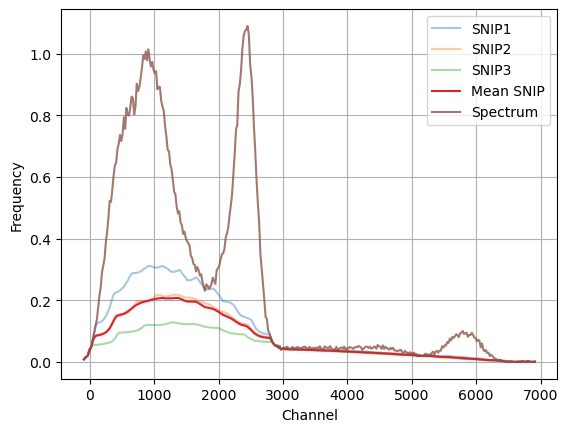

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 67.41 (χ²/ndof = 1.5)      │              Nfcn = 415              │
│ EDM = 2.51e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    292    │    11     │            │            │         │         │       │
│ 1 │ mu     │ 2.4402e3  │ 0.0025e3  │            │            │         │         │       │
│ 2 │ sigma  │   133.1   │    1.7    │            │            │         │         │       │
│ 3 │ A2     │    113    │    11     │            │            │         │         │       │
│ 4 │ mu2    │  2.181e3  │  0.022e3  │            │            │         │         │       │
│ 5 │ sigma2 │    207    │    10     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │       A      mu   sigma      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│      A │     123     -21    15.9 -0.12e3 -0.23e3     -60 │
│     mu │     -21    6.11    -3.5      20      39       1 │
│  sigma │    15.9    -3.5    2.94   -15.3   -28.9    -4.9 │
│     A2 │ -0.12e3      20   -15.3     122  0.23e3      70 │
│    mu2 │ -0.23e3      39   -28.9  0.23e3     472     120 │
│ sigma2 │     -60       1    -4.9      70     120    96.2 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 0.00
Area picco con integrale fit: 405.09 ± 15.68


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 65.64 (χ²/ndof = 1.4)      │              Nfcn = 464              │
│ EDM = 5.27e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    280    │    14     │            │            │         │         │       │
│ 1 │ mu     │ 2.4439e3  │ 0.0031e3  │            │            │         │         │       │
│ 2 │ sigma  │   130.5   │    1.9    │            │            │         │         │       │
│ 3 │ A2     │    105    │    14     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │  2.213e3  │  0.025e3  │            │            │         │         │       │
│ 5 │ sigma2 │    186    │    10     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │       A      mu   sigma      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│      A │     200     -36    21.9  -0.2e3 -0.34e3 -0.09e3 │
│     mu │     -36    9.71    -5.1      35      60       7 │
│  sigma │    21.9    -5.1    3.45   -21.2   -35.5    -6.1 │
│     A2 │  -0.2e3      35   -21.2     198  0.34e3   0.1e3 │
│    mu2 │ -0.34e3      60   -35.5  0.34e3     620  0.17e3 │
│ sigma2 │ -0.09e3       7    -6.1   0.1e3  0.17e3     102 │
└────────┴─────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 68.53 (χ²/ndof = 1.5)      │              Nfcn = 494              │
│ EDM = 4.34e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    115    │    10     │            │            │         │         │       │
│ 1 │ mu     │  2.169e3  │  0.021e3  │            │            │         │         │       │
│ 2 │ sigma  │    213    │    10     │            │            │         │         │       │
│ 3 │ A2     │    297    │    10     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │ 2.4390e3  │ 0.0023e3  │            │            │         │         │       │
│ 5 │ sigma2 │   133.9   │    1.7    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │       A      mu   sigma      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│      A │     108  0.20e3      70 -0.10e3      17   -13.8 │
│     mu │  0.20e3     439     110 -0.21e3      36   -27.1 │
│  sigma │      70     110    95.4     -60       1    -4.8 │
│     A2 │ -0.10e3 -0.21e3     -60     108     -18    14.5 │
│    mu2 │      17      36       1     -18    5.47    -3.2 │
│ sigma2 │   -13.8   -27.1    -4.8    14.5    -3.2    2.79 │
└────────┴─────────────────────────────────────────────────┘

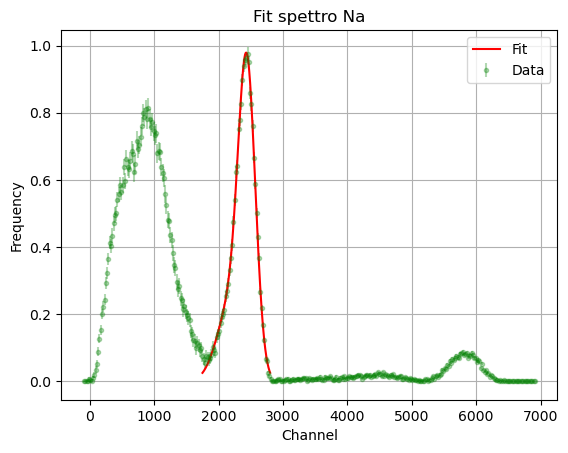

In [48]:
'''

    plastica DI SPESSORE 2.4cm

'''

segnale_24 = pd.read_csv('2.4cm.csv', sep=';', engine='python')
channel_24 = np.array(segnale_0cm['Channel'])
counts_24 = np.array(segnale_24['Counts'])

# calculating frequency and removing background noise
frequency_24_raw = frequency_converter(counts_24, time_signal=3300)
background_24, err_background_24, max_back, min_back= multi_SNIP_algorithm(frequency_24_raw[0], channel_24, iterations=18, delta_n=4)

frequency_24 = (frequency_24_raw[0] - background_24, np.sqrt(frequency_24_raw[1]**2+err_background_24**2))
freq_max = (frequency_24_raw[0] - max_back, np.sqrt(frequency_24_raw[1]**2+err_background_24**2))
freq_min = (frequency_24_raw[0] - min_back, np.sqrt(frequency_24_raw[1]**2+err_background_24**2))

# plot
fig = px.line(x=channel_24, y=frequency_24_raw[0], error_y=frequency_24[1], title='Spettro Na con plastica di spessore 0.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()

# fit
ls = LeastSquares(channel_24, frequency_24[0], frequency_24[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=10, mu2=2000, sigma2=200)
ls.mask = (channel_24 > 1750) & (channel_24 < 2800)
m.migrad()
m.hesse()
display(m)

xaxis = np.linspace(1750, 2800, 3000)
yaxis = func2(xaxis, *m.values)
plt.errorbar(channel_24, frequency_24[0], frequency_24[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [12000, 15600]
for i in range(len(channel_24)):
    if channel_24[i] > integral_extremes[0] and channel_24[i] < integral_extremes[1]:
        freq_integral.append(frequency_24[0][i])
        channel_integral.append(channel_24[i])
        
Area=m.values['A']+m.values['A2']
err_Area=np.sqrt(m.errors['A']**2+m.errors['A2']**2)
print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {Area:.2f} ± {err_Area:.2f}')

intensità_511KeV.append(m.values['A']+m.values['A2'])
err_intensità_511KeV.append(np.sqrt(m.errors['A']**2+m.errors['A2']**2))

#sistematici
ls = LeastSquares(channel_24, freq_max[0], freq_max[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=10, mu2=2000, sigma2=200)
ls.mask = (channel_24 > 1750) & (channel_24 < 2800)
m.limits['A2']= (0, 1000)
m.migrad()
m.hesse()
display(m)
sist1 = m.values['A']+m.values['A2']

ls = LeastSquares(channel_24, freq_min[0], freq_min[1], func2)
m = Minuit(ls, A=470, mu=2500, sigma=200, A2=2, mu2=2200, sigma2=300)
ls.mask = (channel_24 > 1750) & (channel_24 < 2800)
m.limits['A2']= (0, 1000)
m.migrad()
m.hesse()
display(m)
sist2 = m.values['A']+m.values['A2']

err_sist = np.abs(sist1 - sist2)/2

err_sistematico_511KeV.append(err_sist)

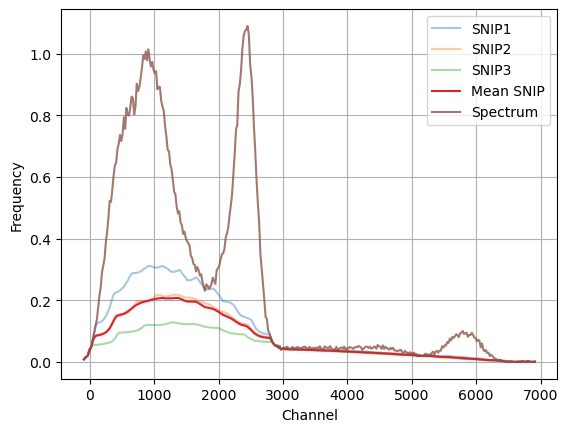

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 82.32 (χ²/ndof = 1.4)      │              Nfcn = 831              │
│ EDM = 4.04e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │   48.4    │    0.6    │            │            │         │         │       │
│ 1 │ mu    │ 5.8132e3  │ 0.0034e3  │            │            │         │         │       │
│ 2 │ sigma │   228.1   │    3.0    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     A    mu sigma │
├───────┼───────────────────┤
│     A │   0.4  -0.2   0.5 │
│    mu │  -0.2  11.3    -1 │
│ sigma │   0.5    -1  8.82 │
└───────┴───────────────────┘

Area picco con integrale trapezoidale: 0.00
Area picco con integrale fit: 48.42 ± 0.63


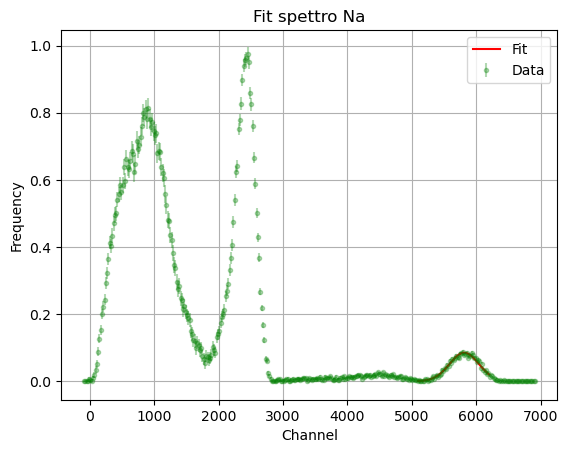

In [49]:
background_24, err_background_24, max_back, min_back= multi_SNIP_algorithm(frequency_24_raw[0], channel_24, iterations=18, delta_n=4)

frequency_24 = (frequency_24_raw[0] - background_24, np.sqrt(frequency_24_raw[1]**2+err_background_24**2))
freq_max = (frequency_24_raw[0] - max_back, np.sqrt(frequency_24_raw[1]**2+err_background_24**2))
freq_min = (frequency_24_raw[0] - min_back, np.sqrt(frequency_24_raw[1]**2+err_background_24**2))


# fit
ls = LeastSquares(channel_24, frequency_24[0], frequency_24[1], func)
m = Minuit(ls, A=0.25, mu=5700, sigma=400)
ls.mask = (channel_24 > 5100) & (channel_24 < 6300)
m.migrad()
m.hesse()
display(m)

xaxis = np.linspace(5100, 6200, 10000)
yaxis = func(xaxis, *m.values)
plt.errorbar(channel_24, frequency_24[0], frequency_24[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [29000, 33000]
for i in range(len(channel_24)):
    if channel_24[i] > integral_extremes[0] and channel_24[i] < integral_extremes[1]:
        freq_integral.append(frequency_24[0][i])
        channel_integral.append(channel_24[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A"]:.2f} ± {m.errors["A"]:.2f}')

intensità_1274_5KeV.append(m.values['A'])
err_intensità_1274_5KeV.append(m.errors['A'])

#sistematici
ls = LeastSquares(channel_04, freq_max[0], freq_max[1], func)
m = Minuit(ls, A=0.25, mu=5700, sigma=400)
ls.mask = (channel_24 > 5100) & (channel_24 < 6300)
m.migrad()
m.hesse()
sist1 = m.values['A']

ls = LeastSquares(channel_04, freq_min[0], freq_min[1], func)
m = Minuit(ls, A=0.25, mu=5700, sigma=400)
ls.mask = (channel_24 > 5100) & (channel_24 < 6300)
m.migrad()
m.hesse()
sist2 = m.values['A']

err_sist = np.abs(sist1 - sist2)/2

err_sistematic0_1274_5KeV.append(err_sist)


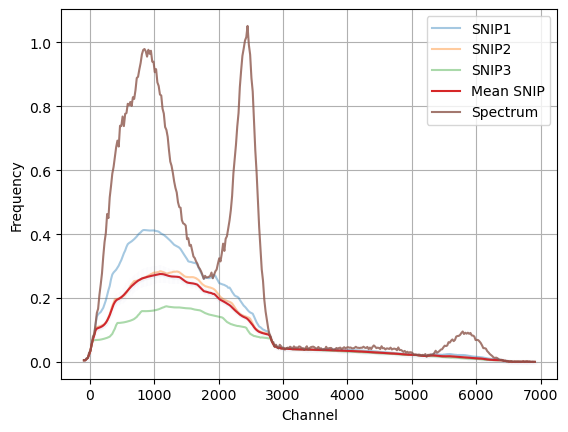

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 99.46 (χ²/ndof = 2.2)      │              Nfcn = 407              │
│ EDM = 9.93e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    260    │    10     │            │            │         │         │       │
│ 1 │ mu     │ 2.4493e3  │ 0.0027e3  │            │            │         │         │       │
│ 2 │ sigma  │   128.5   │    1.6    │            │            │         │         │       │
│ 3 │ A2     │    99     │    10     │            │            │         │         │       │
│ 4 │ mu2    │  2.213e3  │  0.019e3  │            │            │         │         │       │
│ 5 │ sigma2 │    191    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────┐
│        │      A     mu  sigma     A2    mu2 sigma2 │
├────────┼───────────────────────────────────────────┤
│      A │   96.4    -22   13.3    -90   -180    -30 │
│     mu │    -22   7.41   -3.8     20     41     -3 │
│  sigma │   13.3   -3.8    2.6  -12.5  -24.1   -0.8 │
│     A2 │    -90     20  -12.5   91.9    170     30 │
│    mu2 │   -180     41  -24.1    170    377     50 │
│ sigma2 │    -30     -3   -0.8     30     50   62.5 │
└────────┴───────────────────────────────────────────┘

Area picco con integrale trapezoidale: 0.00
Area picco con integrale fit: 359.07 ± 13.72


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 524.9 (χ²/ndof = 11.4)     │              Nfcn = 160              │
│ EDM = 1.93e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │   323.8   │    1.3    │            │            │         │         │       │
│ 1 │ mu     │ 2.4190e3  │ 0.0008e3  │            │            │         │         │       │
│ 2 │ sigma  │   145.8   │    0.7    │            │            │         │         │       │
│ 3 │ A2     │     0     │   0.8e3   │            │            │    0    │  1000   │       │
│ 4 │ mu2    │ -8.8305e3 │ 0.0020e3  │            │            │         │         │       │
│ 5 │ sigma2 │ 1.4971e3  │ 0.0020e3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │     1.65     -0.3      0.3     -0.0      0.0      0.0 │
│     mu │     -0.3    0.719     -0.2     -0.0      0.0      0.0 │
│  sigma │      0.3     -0.2    0.505      0.0     -0.0      0.0 │
│     A2 │     -0.0     -0.0      0.0 5.73e+03        0        0 │
│    mu2 │      0.0      0.0     -0.0        0        4        0 │
│ sigma2 │      0.0      0.0      0.0        0        0        4 │
└────────┴───────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 819.7 (χ²/ndof = 17.8)     │             Nfcn = 1467              │
│ EDM = 8.3e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │   338.4   │    1.3    │            │            │         │         │       │
│ 1 │ mu     │ 2.4145e3  │ 0.0009e3  │            │            │         │         │       │
│ 2 │ sigma  │   150.2   │    0.7    │            │            │         │         │       │
│ 3 │ A2     │   0.00    │   0.26    │            │            │    0    │  1000   │       │
│ 4 │ mu2    │ 2.4848e3  │ 0.0020e3  │            │            │         │         │       │
│ 5 │ sigma2 │   212.9   │    2.0    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │     1.69     -0.3      0.3  -0.1e-6      0.0      0.0 │
│     mu │     -0.3    0.731     -0.3       -0      0.0      0.0 │
│  sigma │      0.3     -0.3    0.519       -0      0.0     -0.0 │
│     A2 │  -0.1e-6       -0       -0 7.73e-07        0       -0 │
│    mu2 │      0.0      0.0      0.0        0        4        0 │
│ sigma2 │      0.0      0.0     -0.0       -0        0        4 │
└────────┴───────────────────────────────────────────────────────┘

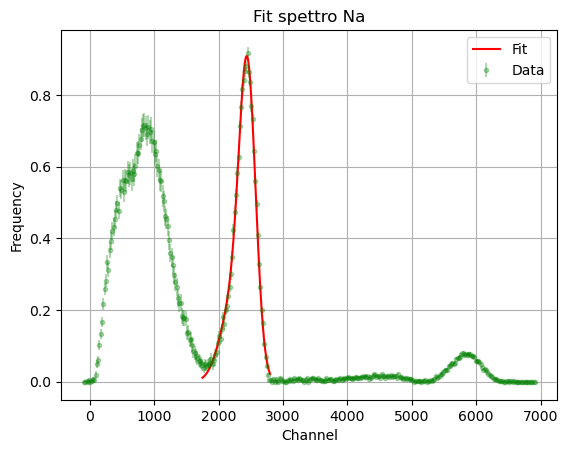

In [50]:
#  plastica DI SPESSORE 3cm



segnale_30 = pd.read_csv('3.0cm.csv', sep=';', engine='python')
counts_30 = np.array(segnale_30['Counts'])
channel_30 = np.array(segnale_30['Channel'])

# calculating frequency and removing background noise
frequency_30_raw = frequency_converter(counts_30, time_signal=5000)
background_30, err_background_30, max_back, min_back= multi_SNIP_algorithm(frequency_30_raw[0], channel_30, iterations=16, delta_n=4)

frequency_30 = (frequency_30_raw[0] - background_30, np.sqrt(frequency_30_raw[1]**2+err_background_30**2))
freq_max = (frequency_30_raw[0] - max_back, np.sqrt(frequency_30_raw[1]**2+err_background_30**2))
freq_min = (frequency_30_raw[0] - min_back, np.sqrt(frequency_30_raw[1]**2+err_background_30**2))

# plot
fig = px.line(x=channel_30, y=frequency_30[0], error_y=frequency_30[1], title='Spettro Na con plastica di spessore 0.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()

# fit
ls = LeastSquares(channel_30, frequency_30[0], frequency_30[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=10, mu2=2000, sigma2=200)
ls.mask = (channel_30 > 1750) & (channel_30 < 2800)
m.migrad()
m.hesse()
display(m)

xaxis = np.linspace(1750, 2800, 3000)
yaxis = func2(xaxis, *m.values)
plt.errorbar(channel_30, frequency_30[0], frequency_30[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [12000, 15600]
for i in range(len(channel_30)):
    if channel_30[i] > integral_extremes[0] and channel_30[i] < integral_extremes[1]:
        freq_integral.append(frequency_30[0][i])
        channel_integral.append(channel_30[i])
        
Area=m.values['A']+m.values['A2']
err_Area=np.sqrt(m.errors['A']**2+m.errors['A2']**2)
print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {Area:.2f} ± {err_Area:.2f}')

intensità_511KeV.append(m.values['A']+m.values['A2'])
err_intensità_511KeV.append(np.sqrt(m.errors['A']**2+m.errors['A2']**2))

#sistematici
ls = LeastSquares(channel_30, freq_max[0], freq_max[1], func2)
m = Minuit(ls, A=470, mu=2400, sigma=200, A2=10, mu2=2000, sigma2=200)
ls.mask = (channel_30 > 1750) & (channel_30 < 2800)
m.limits['A2']= (0, 1000)
m.migrad()
m.hesse()
display(m)
sist1 = m.values['A']+m.values['A2']

ls = LeastSquares(channel_30, freq_min[0], freq_min[1], func2)
m = Minuit(ls, A=470, mu=2500, sigma=200, A2=10, mu2=2200, sigma2=300)
ls.mask = (channel_30 > 1750) & (channel_30 < 2800)
m.limits['A2']= (0, 1000)
m.migrad()
m.hesse()
display(m)
sist2 = m.values['A']+m.values['A2']

err_sist = np.abs(sist1 - sist2)/2

err_sistematico_511KeV.append(err_sist)

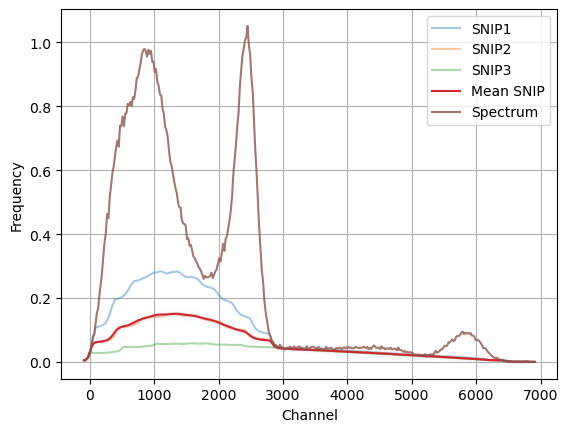

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 61.38 (χ²/ndof = 1.2)      │              Nfcn = 131              │
│ EDM = 3.67e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │   46.4    │    0.5    │            │            │         │         │       │
│ 1 │ mu    │ 5.8287e3  │ 0.0028e3  │            │            │         │         │       │
│ 2 │ sigma │   229.3   │    2.6    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     A    mu sigma │
├───────┼───────────────────┤
│     A │ 0.256 -0.10  0.36 │
│    mu │ -0.10  7.98    -1 │
│ sigma │  0.36    -1  6.58 │
└───────┴───────────────────┘

Area picco con integrale trapezoidale: 0.00
Area picco con integrale fit: 46.39 ± 0.51


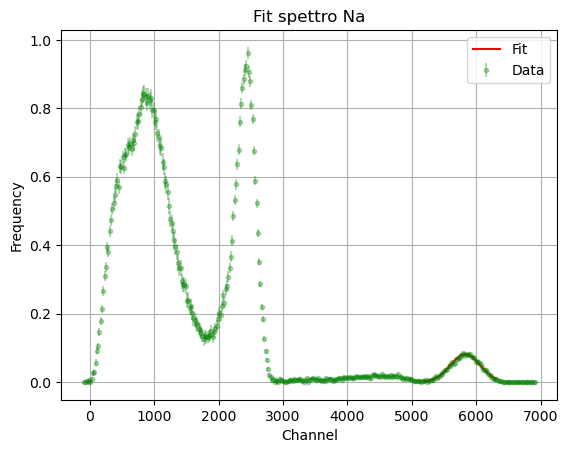

In [51]:
background_30, err_background_30, max_back, min_back= multi_SNIP_algorithm(frequency_30_raw[0], channel_30, iterations=21, delta_n=6)

frequency_30 = (frequency_30_raw[0] - background_30, np.sqrt(frequency_30_raw[1]**2+err_background_30**2))
freq_max = (frequency_30_raw[0] - max_back, np.sqrt(frequency_30_raw[1]**2+err_background_30**2))
freq_min = (frequency_30_raw[0] - min_back, np.sqrt(frequency_30_raw[1]**2+err_background_30**2))


# fit
ls = LeastSquares(channel_30, frequency_30[0], frequency_30[1], func)
m = Minuit(ls, A=1, mu=6000, sigma=300)
ls.mask = (channel_30 > 5200) & (channel_30 < 6300)
m.migrad()
m.hesse()
display(m)

xaxis = np.linspace(5200, 6300, 10000)
yaxis = func(xaxis, *m.values)
plt.errorbar(channel_30, frequency_30[0], frequency_30[1], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

freq_integral = []
channel_integral = []
integral_extremes = [27200, 32000]
for i in range(len(channel_30)):
    if channel_30[i] > integral_extremes[0] and channel_30[i] < integral_extremes[1]:
        freq_integral.append(frequency_30[0][i])
        channel_integral.append(channel_30[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A"]:.2f} ± {m.errors["A"]:.2f}')

intensità_1274_5KeV.append(m.values['A'])
err_intensità_1274_5KeV.append(m.errors['A'])

#sistematici
ls = LeastSquares(channel_30, freq_max[0], freq_max[1], func)
m = Minuit(ls, A=1, mu=6000, sigma=300)
ls.mask = (channel_30 > 5200) & (channel_30 < 6300)
m.migrad()
m.hesse()
sist1 = m.values['A']

ls = LeastSquares(channel_30, freq_min[0], freq_min[1], func)
m = Minuit(ls, A=1, mu=6000, sigma=300)
ls.mask = (channel_30 > 5200) & (channel_30 < 6300)
m.migrad()
m.hesse()
sist2 = m.values['A']

err_sist = np.abs(sist1 - sist2)/2

err_sistematic0_1274_5KeV.append(err_sist)



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.545 (χ²/ndof = 0.6)      │              Nfcn = 73               │
│ EDM = 1.4e-08 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   0.123   │   0.011   │            │            │         │         │       │
│ 1 │ A    │    526    │    13     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        mu         A │
├────┼─────────────────────┤
│ mu │  0.000128 129.36e-3 │
│  A │ 129.36e-3       160 │
└────┴─────────────────────┘

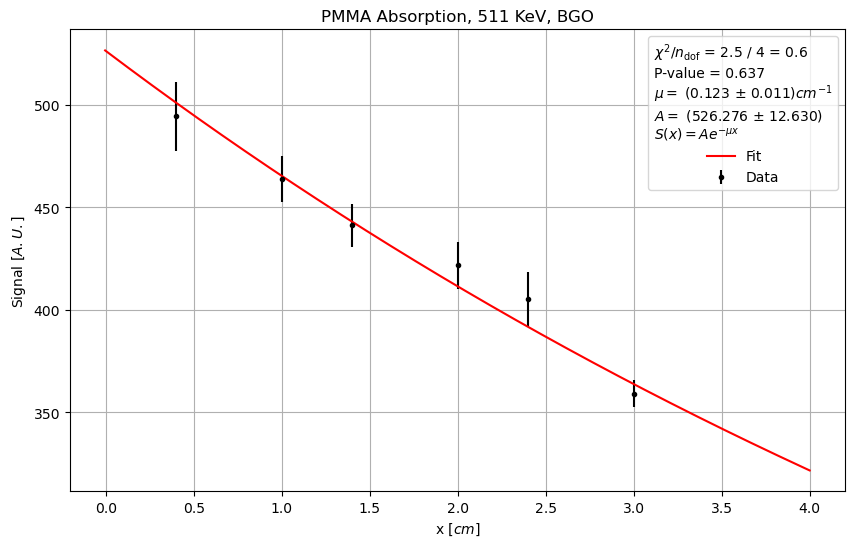

Coefficiente di assorbimento: 0.1231 ± 0.0113
Intensità: [494.38846236 464.06870966 441.19496478 421.69020468 405.08836783
 359.07169169]
Intensità err: [16.78810759 11.25302256 10.63806468 11.28836284 13.33053957  6.59523709]
Spessori: [0.4 1.  1.4 2.  2.4 3. ]


In [52]:
'''

    FIT ASSORBIMENTO con 511KeV

'''

def assorbimento(x, mu, A):
    return A * np.exp(-mu * x)

spessori = np.array([ 0.4, 1, 1.4, 2, 2.4, 3])
intensità = np.array(intensità_511KeV)
intensità_err_stat = np.array(err_intensità_511KeV)
intensità_err_sist= np.array(err_sistematico_511KeV)
intensità_err = np.sqrt(intensità_err_stat**2 + intensità_err_sist**2)

ls = LeastSquares(spessori, intensità, intensità_err_sist, assorbimento)
m = Minuit(ls, mu=0.111, A=300)
m.migrad()
m.hesse()
display(m)

# plot
x_axis = np.linspace(-0.005, 4, 1000)
y = assorbimento(x_axis, m.values['mu'], m.values['A'])
plt.subplots(figsize=(10, 6))
plt.errorbar(spessori, intensità, intensità_err_sist, marker='.', linestyle='', color='black', label='Data', ecolor='black')
plt.plot(x_axis, y, color='red', label='Fit')
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {(m.fval/m.ndof):.1f}",]
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append(f'$\\mu = $ ({m.values["mu"]:.3f} $\\pm$ {m.errors["mu"]:.3f})' + '$cm^{-1}$')
fit_info.append(f'$A = $ ({m.values["A"]:.3f} $\\pm$ {m.errors["A"]:.3f})')
fit_info.append('$S(x) = Ae^{- \mu x}$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid(True)
plt.title('PMMA Absorption, 511 KeV, BGO')
plt.xlabel('x $[cm]$')
plt.ylabel('Signal $[A.U.]$')
plt.show()
print(f'Coefficiente di assorbimento: {m.values["mu"]:.4f} ± {m.errors["mu"]:.4f}')
print(f'Intensità: {intensità}')
print(f'Intensità err: {intensità_err_sist}')
print(f'Spessori: {spessori}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.254 (χ²/ndof = 0.6)      │              Nfcn = 73               │
│ EDM = 1.56e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   0.074   │   0.004   │            │            │         │         │       │
│ 1 │ A    │   57.8    │    0.6    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       mu        A │
├────┼───────────────────┤
│ mu │ 1.93e-05 2.479e-3 │
│  A │ 2.479e-3    0.365 │
└────┴───────────────────┘

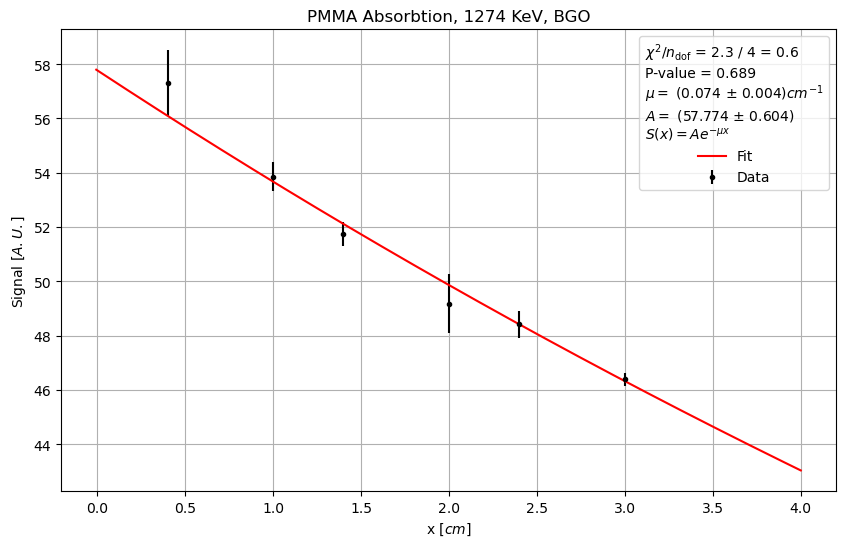

Coefficiente di assorbimento: 0.0736 ± 0.0044
Intensità: [57.29279023 53.85153131 51.74149293 49.17636156 48.41832955 46.38690693]
Intensità err: [1.21127455 0.53756047 0.44472271 1.08536766 0.48837364 0.25337356]
Spessori: [0.4 1.  1.4 2.  2.4 3. ]


In [53]:
'''

    FIT ASSORBIMENTO con 1274.5KeV

'''

def assorbimento(x, mu, A):
    return A* np.exp(-mu * x)

intensità = np.array(intensità_1274_5KeV)
intensità_err_stat = np.array(err_intensità_1274_5KeV)
intensità_err_sist= np.array(err_sistematic0_1274_5KeV)
intensità_err = np.sqrt(intensità_err_stat**2 + intensità_err_sist**2)
'''
area_triangolino = 2.734
intensità = np.array(intensità_1274_5KeV)

rapporto_background = 1 #np.array([np.trapz(background_0), np.trapz(background_04), np.trapz(background_1), np.trapz(background_14), np.trapz(background_20), np.trapz(background_30)])/np.trapz(background_14)
intensità = intensità + area_triangolino * rapporto_background

intensità_err = np.array(err_intensità_1274_5KeV)

'''
ls = LeastSquares(spessori, intensità, intensità_err_sist, assorbimento)
m = Minuit(ls, mu=0.07, A=200)
m.migrad()
m.hesse()
display(m)

# plot
x_axis = np.linspace(-0.005, 4, 1000)
y = assorbimento(x_axis, m.values['mu'], m.values['A'])
plt.subplots(figsize=(10, 6))
plt.errorbar(spessori, intensità, intensità_err_sist, marker='.', linestyle='', color='black', label='Data', ecolor='black')
plt.plot(x_axis, y, color='red', label='Fit')
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {(m.fval/m.ndof):.1f}",]
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append(f'$\\mu = $ ({m.values["mu"]:.3f} $\\pm$ {m.errors["mu"]:.3f})' + '$cm^{-1}$')
fit_info.append(f'$A = $ ({m.values["A"]:.3f} $\\pm$ {m.errors["A"]:.3f})')
fit_info.append('$S(x) = Ae^{- \mu x}$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid(True)
plt.title('PMMA Absorbtion, 1274 KeV, BGO')
plt.xlabel('x $[cm]$')
plt.ylabel('Signal $[A.U.]$')
plt.show()

print(f'Coefficiente di assorbimento: {m.values["mu"]:.4f} ± {m.errors["mu"]:.4f}')
print(f'Intensità: {intensità}')
print(f'Intensità err: {intensità_err_sist}')
print(f'Spessori: {spessori}')

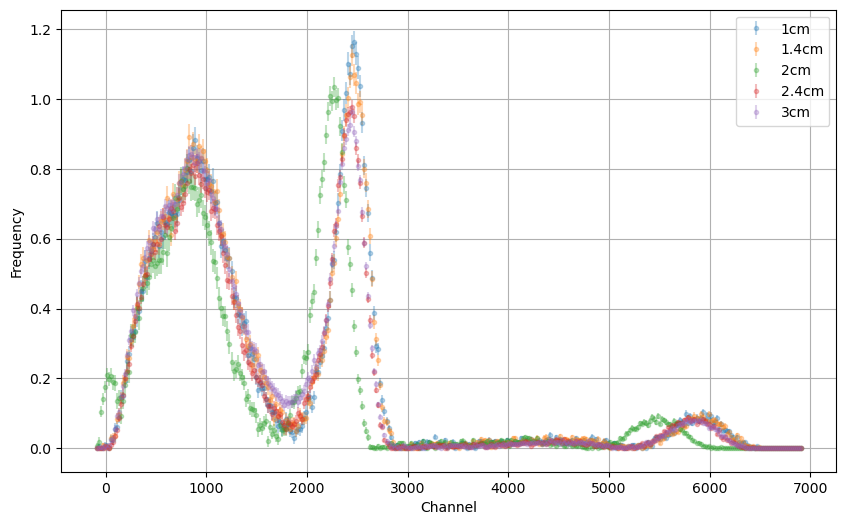

In [54]:

fig = plt.figure(figsize=(10, 6))
plt.errorbar(channel_1, frequency_1[0], frequency_1[1], fmt='.', label='1cm', alpha=0.3)
plt.errorbar(channel_14, frequency_14[0], frequency_14[1], fmt='.', label='1.4cm', alpha=0.3)
plt.errorbar(channel_20, frequency_20[0], frequency_20[1], fmt='.', label='2cm', alpha=0.3)
plt.errorbar(channel_24, frequency_24[0], frequency_24[1], fmt='.', label='2.4cm', alpha=0.3)
plt.errorbar(channel_30, frequency_30[0], frequency_30[1], fmt='.', label='3cm', alpha=0.3) 
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()
